# Pricing of options with local volatilities

### *Objectives*: Calculating and using local volatilities, calculation of european and american options.

We calculate the values of the options using Monte Carlo and partial differential equations (PDE) methods, and compare both methods.

1. We get the parameters needed to calculate the implied volatilities and local volatilities.  
2. We calculate the implied and local volatilities surfaces.
3. We calculate the options' prices using Monte-Carlo and partial differential equations methods.

In [ ]:
"""
pricer_local_vol_for_options.ipynb
==================================
This script calculates pricing call and put option, with Monte Carlo and partial difference equation methods, using both local volatilities.

Dependencies:
- numpy
- math
- time
- scipy
- matplotlib
"""

import numpy as np
import math
import time

from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.linalg import solve_banded

import matplotlib.pyplot as plt
from matplotlib import cm

## Get term-structure inputs.

### Get the zero-coupon rates.

In order to discount the value of the following options, we get the zero-coupon rates from an extrapolation of a sample of zero-coupon rates with their maturities.

*As a reminder*: We get zero-coupon rates from market instruments such as IOS swaps. Their calculation is detailed in **pricer_multicurve_for_vanilla_swap_cap_floor_swaption**.

In [52]:
def generate_zc_rate(yc_maturities, yc_zc_rates):
    """
    Generate a ZC curve based on provided maturities and rates
    """
    # Create an interpolation function for the OIS curve
    yc_zc_rates_interp = interp1d(yc_maturities, yc_zc_rates, kind='cubic', fill_value="extrapolate")
    return yc_zc_rates_interp

### Calculate discount factors from zero-coupon rates.

Discount factors are calculated using continuous compounding.

$DF(t) = e^{-z_c(t) * t}$

In [53]:
def DF(t, yc_zc_rates_interp):
    """
    Calculate the discount factor for a given maturity t.
    """
    return math.exp(-yc_zc_rates_interp(t) * t)

We print a graph of zero-coupon rates to give an overview of the tendency of the rates over different maturities. 

In [54]:
def plot_curve(yc_maturities, yc_zc_rates, yc_zc_rates_interp):
    """
    Plot the zero-coupon curve.
    """
    maturities = np.linspace(0, yc_maturities[-1], 100)
    plt.figure(figsize=(10, 6))
    plt.plot(yc_maturities, yc_zc_rates, 'o', maturities, yc_zc_rates_interp(maturities), label='Zero-Coupon Curve')
    plt.xlabel('Maturity (years)')
    plt.ylabel('Zero-Coupon Rate')
    plt.title('Zero-Coupon Curve')
    plt.legend(['data', 'interpolated'], loc='best')
    plt.grid()
    plt.show()

### Get forward rates.

We get the forward rates from an extrapolation of a sample of forward rates with their maturities (similar to zero-coupon rates).  

*As a reminder*: We get forward rates from market instruments such as EURIBOR 6/3M swaps. Their calculation is detailed in **pricer_multicurve_for_vanilla_swap_cap_floor_swaption**.

In [55]:
def generate_S_forwards(S_maturities, S_forwards):
    """
    Generate a forward rate curve based on maturities and forward rates
    """
    S_forwards_interp = interp1d(S_maturities, S_forwards, kind='cubic', fill_value="extrapolate")
    return S_forwards_interp

### Get SABR parameters.

We get the SABR parameters from an extrapolation of a sample of these SABR parameters with their maturities.  

*As a reminder*: We get SABR parameters from market implied volatilities observed on a smile of volatility.

SABR parameters are :
- $\alpha$ : initial volatility of the forward 
- $\beta$ : elasticity ($\beta = 1$ for lognormal i.e. Black ; $\beta = 0$ for normal ; $0 < \beta < 1$ as intermediary)
- $\rho$ : forward/volatility correlation to control the asymetry of the smile of volatility
- $\nu$ : volatility of the volatility (vol-vol) to control the curvature of the smile of volatility


In [56]:
def generate_S_alpha(S_maturities, S_alpha):
    """
    Calculate the alpha parameter for the SABR model: the volatility of the forward rate.
    """
    S_alpha_interp = interp1d(S_maturities, S_alpha, kind='cubic', fill_value="extrapolate")
    return S_alpha_interp


def generate_S_beta(S_maturities, S_beta):
    """
    Calculate the beta parameter for the SABR model: the elasticity of the forward rate.
    """
    S_beta_interp = interp1d(S_maturities, S_beta, kind='cubic', fill_value="extrapolate")
    return S_beta_interp


def generate_S_rho(S_maturities, S_rho):
    """
    Calculate the rho parameter for the SABR model: the correlation between the forward rate and its volatility.
    """
    S_rho_interp = interp1d(S_maturities, S_rho, kind='cubic', fill_value="extrapolate")
    return S_rho_interp


def generate_S_nu(S_maturities, S_nu):
    """
    Calculate the nu parameter for the SABR model: the volatility of the volatility.
    """
    S_nu_interp = interp1d(S_maturities, S_nu, kind='cubic', fill_value="extrapolate")
    return S_nu_interp

## Calculate and plot the implied and local volatilities surfaces.

We get the local volatilities, the basis for options pricing, from the implied volatilities, which are calculated using the SABR model.

### Calculate implied volatilities from the SABR model.

The SABR model generates smiles of volatility close enough of volatilities observed in the market.

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \frac{z}{x(z)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $

*avec* :   
$z = \frac{\nu}{\alpha} (F K)^{\frac{1-\beta}{2}} \ln \frac{F}{K}$  

$x(z) = \ln \left( \frac{ \sqrt{1 - 2 \rho z + z^2} + z - \rho }{1 - \rho} \right)$ 

*Particular case $ \Rightarrow $ when K = F (ATM)* :

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $


In [57]:
def sabr_vol(T, K, F0, alpha, beta, rho, nu):
    """
    Calculate the SABR volatility for given parameters.
    Hagan's 2002 SABR lognormal volatility expansion.
    """
    eps = 1e-07
    logfk = np.log(F0 / K)
    fkbeta = (F0*K)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * nu * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * nu**2 / 24.
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = nu * fkbeta**0.5 * logfk / alpha
    tmp = alpha * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    """
    Return function x used in Hagan's 2002 SABR lognormal volatility expansion.
    """
    a = (1 - 2*rho*z + z**2)**0.5 + z - rho
    b = 1 - rho
    return np.log(a / b) 

In [58]:
def implied_vol(T, K, params_SABR):
    """
    Calculate the implied volatility using the SABR model.
    """
    F0 = params_SABR['S_forwards'](T)
    alpha = params_SABR['S_alpha'](T)
    beta = params_SABR['S_beta'](T)
    rho = params_SABR['S_rho'](T)
    nu = params_SABR['S_nu'](T)
    
    return sabr_vol(T, K, F0, alpha, beta, rho, nu) 

### Calculate local volatilities.

From the implied volatilities, we calculate the local volatilities using the Dupire's formula.   
The local volatilities will be then used for calculation of options pricing based on time left to maturity and on-going underlying value.

$\sigma_{\text{loc}}^2(K,T) =
\frac{2\frac{\partial \hat{\sigma}}{\partial T} + \frac{\hat{\sigma}}{T} + 2K\mu(T)\frac{\partial \hat{\sigma}}{\partial K}}
{K^2\left[\frac{\partial^2 \hat{\sigma}}{\partial K^2} - d_1\sqrt{T}\left(\frac{\partial \hat{\sigma}}{\partial K}\right)^2 + \frac{1}{\hat{\sigma}}
\left(\frac{1}{K\sqrt{T}} + d_1\frac{\partial \hat{\sigma}}{\partial K}  \right)^2 \right]}$

*avec*:   

$d_1 = \frac{ln\frac{S_0}{K} + \int_0^T \mu(s)\,ds }{\hat{\sigma}\sqrt{T}} + \frac{1}{2}\hat{\sigma}\sqrt{T} $

*where* 
$\hat{\sigma}$ is the implied volatility

In [59]:
def local_vol(t, S, S0, params_SABR):
    """
    Calculate the local volatility using the Dupire's formula.
    """
    S_forwards = params_SABR['S_forwards']

    t = np.where(t == 0, 1e-08, t) # to avoid divide by 0
    eps_t = 1e-07
    eps_S = eps_t * S
    vol = implied_vol(t, S, params_SABR)
    sqrt_t = np.sqrt(t)
    drift = np.log(S_forwards(t + eps_t) / S_forwards(t)) / eps_t
    dvol_dT = (implied_vol(t + eps_t, S, params_SABR) - vol) / eps_t
    vol_plus  = implied_vol(t, S + eps_S, params_SABR)
    vol_minus = implied_vol(t, S - eps_S, params_SABR)
    dvol_dK = (vol_plus - vol) / eps_S
    d2vol_dK2 = (vol_plus + vol_minus  - 2 * vol) / eps_S**2
    d1 = (np.log(S0 / S) + np.log(S_forwards(t) / S0) + 0.5 * vol**2 * t) / (vol * sqrt_t)
    num = 2 * dvol_dT + vol / t + 2 * S * drift * dvol_dK
    den = S**2 * (d2vol_dK2 - d1*sqrt_t*dvol_dK**2 + (1/(S*sqrt_t) + d1*dvol_dK)**2 / vol)
    
    return np.sqrt(np.where(num/den >= 0, num/den, 0))

### Plot the implied and local volatilities' surfaces

We plot the surfaces to give an overview of the volatilities depending on time to maturity and underlying value.

In [60]:
def plot_implied_vol_surface(T, K, params_SABR):
    """
    Plot the implied volatility surface.
    """
    K, T = np.meshgrid(K, T) # Create a grid for strike prices and maturities
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection='3d')
    vols = implied_vol(T, K, params_SABR)
    surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    
    ax.view_init(elev=20, azim=-50) # Set the viewing angle
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Maturity (years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface')
    plt.show()

In [61]:
def plot_local_vol_surface(T, S, S0, params_SABR):
    """
    Plot the local volatility surface.
    """
    T, S = np.meshgrid(T, S) # Create a grid for time and forward rates
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection='3d')
    vols = local_vol(T, S, S0, params_SABR)
    surf = ax.plot_surface(S, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    
    ax.view_init(elev=20, azim=-50) # Set the viewing angle
    ax.set_xlabel('Forward Rate')
    ax.set_ylabel('Time to Maturity (years)')
    ax.set_zlabel('Local Volatility')
    ax.set_title('Local Volatility Surface')
    plt.show()

## Calculate the option prices with Monte Carlo simulation method.

The prices of options depend on the values of the underlying.  
Consequently as a 1st step, we calculate the values of the underlying over its maturity.

### Calculate the underlying values.

1. We use the Black model (lognormal model) to calculate the range of values of the underlying's forward over the maturity (in order to get then the local volatility).  
There is a discretization of the maturity over a predefined number of points.

$S_{max} = S_0 e^{-\frac{1}{2}\sigma^2t + \sigma \sqrt{t}} $

$S_{min} = S_0 e^{-\frac{1}{2}\sigma^2t - \sigma \sqrt{t}} $


2. We identify the local volatility for each discretized point of time and the corresponding underlying's forward value.

3. We calculate the drift of the underlying between each point of time.

$ \mu = \frac{S_t}{S_t-1}$

4. Using the Black-Scholes model, we simulate a set of values of the underlying with Monte Carlo.  
The simulation with Monte Carlo uses the Gaussian function.

$S_{t+1} = S_t e^{(\mu - \frac{1}{2}\sigma^2)dt + \sigma\sqrt{dt}*Z}$

*where*:  
Z the Gaussian function $\mathcal{N}(0,1)$


In [62]:
def stock_prices(S_forwards, t, dt, n_steps, n_simul, S_paths, params_SABR, S0, n_stdev):
    """
    Simulation the possible prices of a stock.
    We use the stock prices at time t[i] to simulate the stock prices at time t[i+1].
    We assume that the stock prices at time t[i] are known.
    We use the local volatility at time t[i+1] to simulate the stock prices at time t[i+1].
    """
    prev_fwd = S0 # initial forward price
    Z = np.random.normal(0, 1, (n_steps, n_simul)) # pre-generate all random numbers
    
    for i in range(n_steps):
        fwd = S_forwards(t[i+1])
        vol = implied_vol(t[i+1], fwd, params_SABR)
        Smax = fwd * math.exp(-0.5 * vol**2 * t[i+1] + n_stdev * vol * math.sqrt(t[i+1])) # max stock prices at time t[i+1]
        Smin = fwd * math.exp(-0.5 * vol**2 * t[i+1] - n_stdev * vol * math.sqrt(t[i+1])) # min stock prices at time t[i+1]
        Sinterp = np.linspace(Smin, Smax, n_steps + 1, endpoint=True)                     # stock prices at time t[i+1] 

        # Interpolate the local volatility for the stock prices at time t[i] (interpolation is much faster than sigma = local_vol(t[j], S[j,:]))
        local_vol_interp = interp1d(Sinterp, local_vol(t[i], Sinterp, S0, params_SABR), kind='cubic', fill_value='extrapolate') 
        sigma_local = local_vol_interp(S_paths[i, :]) 

        mu = math.log(fwd / prev_fwd) / dt # drift
        prev_fwd = fwd

        # Generate n_simul random numbers from a standard normal distribution            
        S_paths[i+1, :] = S_paths[i, :] * np.exp((mu - 0.5 * sigma_local**2) * dt + sigma_local * math.sqrt(dt) * Z[i, :])
    
    return S_paths
    

### Calculate the options values based on the Monte Carlo simulation.

We calculate the price of european options using the set of values of the underlying at maturity.  
The price of the options is based on the mean of the set of discounted option's values at maturity, i.e. the mean of the set of discounted simulated payoffs.   

The payoff depends on the type "call" or "put" of the option (see below).  

We calculate the standard deviation of this set of values to identify the confidence range.  

*N.B.*: We don't use Monte Carlo method for path-dependent instruments such as american options.

In [63]:
def mc_option_pricing(payoff, black_payoff, implied_vol, T, S_forwards_interp, yc_zc_rates_interp, S_paths, K, n_simul, params_SABR, option_type):
    """
    Price a European option using Monte Carlo simulation under the local volatility model.
    """    
    price = np.mean(payoff(T, yc_zc_rates_interp, S_paths, K))
    stdev = np.std(payoff(T, yc_zc_rates_interp, S_paths, K))
    IClow = price - 1.96 * stdev / math.sqrt(n_simul)
    ICup = price + 1.96 * stdev / math.sqrt(n_simul)

    F = S_forwards_interp(T)
    black_price = black_payoff(F, K, T, implied_vol, yc_zc_rates_interp, params_SABR)

    print(f"European {option_type} Option Price (Monte Carlo): {price:.4f} (95% Confidence Interval: [{IClow:.4f}, {ICup:.4f}])")    
    print(f"European {option_type} Option Price (Black): {black_price:.4f}")

### Calculate the value of an european call option.  

From the price at maturity of the underlying, we calculate the discounted payoff of the option.  

$C_0 = e^{-rT} max(S_T - K; 0)$

In [64]:
def european_call_payoff(T, yc_zc_rates_interp, S_paths, K): 
      """
      Calculate the payoff of a European call option.
      """
      return DF(T, yc_zc_rates_interp) * np.maximum(S_paths[-1, :] - K, 0)


### Calculate the value of an european put option.  

From the price at maturity of the underlying, we calculate the discounted payoff of the option.   

$P_0 = e^{-rT} max(K - S_T; 0)$

In [65]:
def european_put_payoff(T, yc_zc_rates_interp, S_paths, K): 
      """
      Calculate the payoff of a European put option.
      """
      return DF(T, yc_zc_rates_interp) * np.maximum(K - S_paths[-1, :], 0)

## Calculate the option prices with the Black formula

We calculate the option prices of european options in order to compare the results with option prices calculated using Monte Carlo and PDE methods.

### Calculate the value of a call option with the Black formula

$C_0 = e^{-rT}\left[F\mathcal{N}(d1) - K\mathcal{N}(d2)\right]$

*with*:   
$d1 = \frac{log\frac{F}{K}+(\frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$    

$d2 = d1 - \sigma \sqrt{T}$

In [66]:
def black_call(F, K, T, implied_vol, yc_zc_rates_interp, params_SABR):
    """
    Calculate the Black price of a European call option.
    """
    sigma = implied_vol(T, K, params_SABR)
    
    d1 = (math.log(F / K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    return DF(T, yc_zc_rates_interp) * (F * norm.cdf(d1) - K * norm.cdf(d2))

### Calculate the value of a put option with the Black formula

$P_0 = e^{-rT} \left[K\mathcal{N}(-d2) - S_0\mathcal{N}(-d1)\right] $

In [67]:
def black_put(F, K, T, implied_vol, yc_zc_rates_interp, params_SABR):
    """
    Calculate the Black price of a European put option.
    """
    sigma = implied_vol(T, K, params_SABR)
    
    d1 = (math.log(F / K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    return DF(T, yc_zc_rates_interp) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

## Calculate the option prices with partial differential equation (PDE) method.

We try to identify the value $\upsilon(t,S_t)$ of the option at $t$ for the underlying spot value $S_t$.

1. Using Itô's lemma, we get the partial differential equation for $\upsilon(t,S_t)$:

$d\upsilon(t,S_t) = \frac{\partial\upsilon}{\partial t}(t,S_t) + \frac{\partial\upsilon}{\partial s}(t,S_t)dS_t + 
\frac{1}{2}\frac{\partial^2\upsilon}{\partial s^2}(t,S_t)^2 S_t^2 dt$

2. Under the risk-neutral measure, the dynamic of the underlying is:

$\frac{dS_t}{S_t} = \mu(t)dt + \sigma(t,S_t)dW_t$

3. So we replace $dS_t$ in the PDE with the dynamic of the underlying :

$d\upsilon(t,S_t) = \left[\frac{\partial\upsilon}{\partial t}(t,S_t) + \mu(t)S_t\frac{\partial\upsilon}{\partial s}(t,S_t) + 
\frac{1}{2}\sigma(t,S_t)^2 S_t^2\frac{\partial^2\upsilon}{\partial s^2}(t,S_t) \right] dt + \sigma(t,S_t)S_t\frac{\partial\upsilon}{\partial s}(t,S_t)dW_t $

4. Moreover, the value $\upsilon(t,S_t)$ of the option, as an asset, has as drift a risk free short rate $r(t)$ :

$d\upsilon(t,S_t) = r(t)\upsilon(t,S_t)dt + (...)dW_t$

5. Considering the drift part of both equations, we consequently get :

$ \frac{\partial\upsilon}{\partial t}(t,S_t) + \mu(t)S_t\frac{\partial\upsilon}{\partial s}(t,S_t) + 
\frac{1}{2}\sigma(t,S_t)^2 S_t^2\frac{\partial^2\upsilon}{\partial s^2}(t,S_t) - r(t)\upsilon(t,S_t) = 0 $

6. Using the finite difference method (see below) to approximate the solution of the PDE, we get the value $\upsilon(t,S_t)$ of the option at $t = t_0$ for the underlying spot value $S_t = S_0$.

### Calculate the prices of the underlying over the maturity.

Using the finite difference method to calculate the price of the options, we first calculate the range of values of the underlying at maturity. 

We use the mean of local volatilities between the expected forward value at maturity of the option and the current value of the underlying, to calculate the future values of the underlying.    
The values of the underlying at maturity is calculated under the binomial tree model.

$S_{T_{max}} = S_0 e^{\sigma\sqrt{T}}$

$S_{T_{min}} = S_0 e^{-\sigma\sqrt{T}}$

In [68]:
def stock_values(T, S0, S_forwards_interp, params_SABR, ns, n_stdev):
    """
    Calculation of the stock price range for the finite difference method.
    """
    avg_vol = (local_vol(0, S0, S0, params_SABR) + local_vol(T, S_forwards_interp(T), S0, params_SABR)) / 2
    u = math.exp(n_stdev * avg_vol * math.sqrt(T))
    Smax = S0 * u
    Smin = S0 / u
    
    return np.linspace(Smin, Smax, ns, endpoint=True) # stock price grid


### Calculate the option prices using the finite difference method.

We discretize the PDE in time $t$ and space $s$ to solve it backward, from the maturity $T$ with a condition for limit depending on the type of option (see below) to $t = 0$.  

Discretization are done as following :

- $\frac{\partial\upsilon}{\partial s}(t,s) \approx \frac{\upsilon(t,s^+) - \upsilon(t,s^-)}{s^+ - s^-} $ as the derivation of 1st order.

- $\frac{\partial^2\upsilon}{\partial s^2}(t,s) \approx 2\left[\frac{\upsilon(t,s^+) - \upsilon(t,s)}{(s^+ - s^-)(s^+ - s)} - \frac{\upsilon(t,s) - \upsilon(t,s^-)}{(s^+ - s^-)(s - s^-)}\right]$ as the derivation of 2nd order.

1. Consequently the discretized PDE is :

$\upsilon(t^+,s) - \upsilon(t,s) + A\upsilon(t,s) = 0  \Rightarrow $ *implicit schema* 

*where*:  
$A\upsilon(t,s) = \left[\mu(t)s \frac{\upsilon(t,s^+) - \upsilon(t,s^-)}{s^+ - s^-}\right] + \left[\frac{1}{2} \sigma(t,s)^2s^2(t^+ - t) * 2\left(\frac{\upsilon(t,s^+) - \upsilon(t,s)}{(s^+ - s^-)(s^+ - s)} - \frac{\upsilon(t,s) - \upsilon(t,s^-)}{(s^+ - s^-)(s - s^-)}\right) \right]- r(t,s)\upsilon(t,s) $


2. It is possible to get $A\upsilon$ for $t^+$ instead of $t$ :

$\upsilon(t^+,s) - \upsilon(t,s) + A\upsilon(t^+,s) = 0  \Rightarrow $ *explicit schema* 

*N.B.* : The implicit schema is more stable, and the explicit schema needs a higher discretization to converge.


3. Nevertheless we use here a mix of both schemas : the $\theta$-schema :

$\upsilon(t^+,s) - \upsilon(t,s) + \theta A \upsilon(t,s) + (1 - \theta) A \upsilon(t^+,s) = 0 $

*with* : $\theta = 0.5 \Rightarrow $ *Crank-Nicholson schema*

4. With the Crank-Nicholson method, we transform the PDE into a linear system : $LV^{t+1} = RV^t$.    

*where*:  
$L$ a tridiagonal matrix to solve the system at each $t$.   
$R$ a tridiagonal matrix to update the solution $\upsilon(t,s) $.  
$V_{t+1}$ and $V_t$ vectors for the prices of the option at both $t$ and $t+1$.  

Tridiagonal matrices are used due to the finite difference method where $\upsilon(t,s)$ depends on only immediate close points $s^+$ and $s^-$.

Values/coefficients in the matrices are got from the $\theta$-schema:   
$p^l_u\upsilon(t,s^+) + p^l_c\upsilon(t,s) + p^l_d\upsilon(t,s^-) = p^r_u\upsilon(t^+,s^+) + p^u_c\upsilon(t^+,s) + p^u_d\upsilon(t^+,s^-) $

*where* :   
$p^l_u = - \theta \alpha _u $.  
$p^l_c = - \theta \alpha _c + 1 + \theta r(t) $.  
$p^l_d = - \theta \alpha _d $.  
$p^r_u = (1 - \theta) \alpha _u $.  
$p^r_c = (1 - \theta) \alpha _c + 1 - (1 -\theta) r(t) $.  
$p^r_d = (1 - \theta) \alpha _d $.   

*and* :   
$\alpha _u = \frac{\sigma(t,s)^2s^2(t^+-t) + \mu(t)s(s^+-s)}{(s^+-s^-)(s^+-s)}$

$\alpha _c = -\sigma(t,s)^2s^2(t^+-t)\left[ \frac{1}{(s^+-s^-)(s^+-s)} + \frac{1}{(s^+-s^-)(s-s^-)} \right]$

$\alpha _d = \frac{\sigma(t,s)^2s^2(t^+-t) - \mu(t)s(s^+-s)}{(s^+-s^-)(s^+-s)}$


5. We consider the conditions to the limits, simplifying the coefficients.

If we don't have $\upsilon(t,s^+)$ so we use $\frac{\upsilon(t,s) - \upsilon(t,s^-)}{s - s^-} $ as the derivation of 1st order, and 0 as as the derivation of 2nd order.

Consequently the equation becomes :   
$p^l_c\upsilon(t,s) + p^l_d\upsilon(t,s^-) = p^r_c\upsilon(t^+,s) + p^r_d\upsilon(t^+,s^-) $

*with* :  
$\alpha _c = \frac{\mu(t)s}{s-s^-} $.    
$\alpha _d = - \alpha _c $

If we don't have $\upsilon(t,s^-)$, similarly we get :
$p^l_u\upsilon(t,s^+) + p^l_c\upsilon(t,s) = p^r_u\upsilon(t^+,s^+) + p^u_c\upsilon(t^+,s) $

*with* :  
$\alpha _u = \frac{\mu(t)s}{s^+-s} $.     
$\alpha _c = - \alpha _u $

In the script, we use the library *solve_banded* to reverse the tridiagonal matrices and identify the vector $V_t$ at each iteration until $V_0$.   


In [69]:
def pde_option_pricing(payoff, T, t, dt, n_steps, S_grid, ns, S0, S_forwards_interp, yc_zc_rates_interp, K, params_SABR, option_type):
    """
    Price a European option using the finite difference method under the local volatility model.
    3.1. The stock price space is discretized using a grid. 
    3.2. The calculation is done using a finite difference method to solve the Black-Scholes PDE with local volatility.
    """
    
    t_start = time.time()
    theta = 0.5 # Crank-Nicolson scheme (0: explicit, 1: implicit, 0.5: Crank-Nicolson)

    nt = n_steps + 1 # number of time steps including t=0
    ds = (S_grid[-1] - S_grid[0]) / (ns - 1) # stock price step
    
    v = np.zeros((nt, ns)) # option price grid
    v[-1,:] = payoff(T, t[-1], v[-1,:], S_grid, K) # terminal condition

    # Coefficients for the tridiagonal matrix
    # Backward loop from t = t_max - dt to t = 0
    for i in range(nt-2, -1, -1):

        # Parameters at time t[i]
        vol = local_vol(t[i], S_grid, S0, params_SABR) # local volatility at time t[i]
        drift = math.log(S_forwards_interp(t[i+1]) / S_forwards_interp(t[i])) / dt # drift
        var =  (vol * S_grid)**2 * dt # variance
        mu = drift * S_grid * dt # mean
        r = math.log(DF(t[i], yc_zc_rates_interp) / DF(t[i+1], yc_zc_rates_interp)) # short rate

        # Coefficients for the tridiagonal matrix
        alpha_u = (var + mu * ds) / (2 * ds**2) # upper diagonal
        alpha_c = -var / ds**2.                 # main diagonal
        alpha_d = (var - mu * ds) / (2 * ds**2) # lower diagonal 

        # Boundary conditions
        alpha_u[0]  = mu[0] / ds
        alpha_c[0]  = -alpha_u[0]
        alpha_d[0]  = 0.
        alpha_u[-1] = 0.
        alpha_c[-1] = mu[-1] / ds
        alpha_d[-1] = -alpha_c[-1]        

        # Set up the tridiagonal system
        p_ur = (1.-theta)*alpha_u
        p_dr = (1.-theta)*alpha_d
        p_cr = (1.-theta)*alpha_c + 1. - (1.-theta)*r
        p_ul = -theta*alpha_u
        p_dl = -theta*alpha_d
        p_cl = -theta*alpha_c + 1. + theta*r

        # Right-hand side   
        right = np.empty(ns)
        right[0] = p_cr[0]*v[i+1, 0] + p_ur[0]*v[i+1, 1]
        right[1:ns-1] = p_dr[1:ns-1]*v[i+1,0:ns-2] + p_cr[1:ns-1]*v[i+1,1:ns-1] + p_ur[1:ns-1]*v[i+1,2:ns]
        right[-1] = p_cr[-1]*v[i+1,-1] + p_dr[-1]*v[i+1,-2]        

        # Algorithm to solve the tridiagonal system
        # We use the scipy.linalg.solve_banded function to solve the tridiagonal system
        upper_band = np.insert(p_ul, 0, 0.)[:-1] # transform p_ul to call solve_banded (0 must be in first position)
        lower_band = np.append(p_dl[1:ns], 0)  # transform p_ul to call solve_banded (0 must be in last position)
        tridiag = np.array([upper_band, p_cl, lower_band])
        v[i,:] = solve_banded((1, 1), tridiag, right)      

        v[i,:] = payoff(T, t[i], v[i,:], S_grid, K)  # apply the payoff function to the option price grid

    # Interpolate to find the option price at S0
    price_interp = interp1d(S_grid, v[0,:], kind='linear')

    print(f"{option_type} Option Price (Finite Difference Method): {price_interp(S0):.4f}")
    print(f"Finite Difference Method computation time: {time.time() - t_start:.2f} seconds")     

### Calculate the value of an european call option.  

From the prices at maturity T of the underlying, we calculate the possible payoffs of the option. 

$C_T = max(S_T - K; 0)$.  

From these possible payoffs, we perform the finite difference method (above) until $t_0$ to identify the values of the option.



In [70]:
def pde_european_call_payoff(T, t, v, S_grid, K):
    """
    Payoff function for a European Call option.
    """
    if (math.isclose(t,T)):
	    v = np.maximum(S_grid - K, 0) 
     
    return v


### Calculate the value of an european put option.  

From the prices at maturity T of the underlying, we calculate the possible payoffs of the option.  

$P_T = max(K - S_T; 0)$.  

Similar to call, from these possible payoffs, we perform the finite difference method (above) until $t_0$ to identify the values of the option.

In [71]:
def pde_european_put_payoff(T, t, v, S_grid, K):
    """
    Payoff function for a European Put option.
    """
    if (math.isclose(t,T)):
	    v = np.maximum(K - S_grid, 0) 
     
    return v 

### Calculate the value of an american call option.  

An american option can be triggered at each step and therefore its calculated value is compared to the payoff of the call option as if the option terminates now. 
 
Similar to european options, we perform the finite difference method (above) until $t_0$ to identify the values of the option and compare them to the payoffs at each step. 

$V_{t,k} = max (S_{t,k} - K, e^{-r\Delta t} (V_{t+\Delta t,k}))$.  
 

In [72]:
def pde_american_call_payoff(T, t, v, S_grid, K):
    """
    Payoff function for a American Call option.
    """
    return np.maximum(S_grid - K, v) 

### Calculate the value of an american put option.  

As the american call option, the calculated value is compared to the value of the put option as if the option terminates now.

$V_{t,k} = max (K - S_{t,k}, e^{-r\Delta t} (V_{t+\Delta t,k}))$.  


In [73]:
def pde_american_put_payoff(T, t, v, S_grid, K):
    """
    Payoff function for a American Call option.
    """
    return np.maximum(K - S_grid, v) 

## Execution of the project

In [74]:
def main():

    """Main function to execute are the following steps."""

    """
    1. The ZC curve generation and plotting.
    This curve is generated here based on hard-coded maturities and rates, but could be replaced with real market data.
    """

    # Define inputs of maturities and rates for the ZC curve
    yc_maturities = np.array([0, 1, 2, 5, 10, 15, 20, 30])
    yc_zc_rates = np.array([-0.55, -0.52, -0.51, -0.4, -0.18, 0.02, 0.11, 0.09]) * 0.01
    yc_zc_rates_interp = generate_zc_rate(yc_maturities, yc_zc_rates) 

    # Plot the ZC curve
    plot_curve(yc_maturities, yc_zc_rates, yc_zc_rates_interp)

    """"
    2. The implied volatility and local volatility surfaces generation and plotting.
    These surfaces are generated here based on hard-coded SABR parameters term structure, although in practice it would be derived from market data.
    The SABR model is used to generate the implied volatility surface, from which the local volatility surface is derived.
    """

    # Define inputs for both implied volatility and local volatility surfaces using SABR model parameters
    S0 = 100.0  # Initial forward rate

    S_maturities = np.array([0.08, 0.25, 0.50, 1.00, 1.50, 2.00])
    S_forwards = np.array([99.9563, 99.8655, 99.7354, 99.4813, 99.2301, 98.9851]) # S_forwards = S0 * np.exp((yc_zc_rates_interp(S_maturities) * S_maturities)
    S_alpha = np.array([20.0, 18.5, 17.4, 16.5, 15.5, 14.5]) * 0.01  # SABR alpha parameters i.e. initial volatilities
    S_beta = np.full(6, 1.)                                          # SABR beta parameters i.e. elasticity of the forward rate (the Brownian motion) 
    S_rho = np.array([-0.4, -0.35, -0.3, -0.3, -0.3, -0.3])          # SABR rho parameters i.e. correlation between forward and volatility (the Brownian motions)     
    S_nu = np.array([95, 80, 70, 60, 50, 40]) * 0.01                 # SABR nu parameters i.e. volatility of volatility

    # Interpolate the forward rates and SABR parameters
    S_forwards_interp = generate_S_forwards(S_maturities, S_forwards)
    S_alpha_interp = generate_S_alpha(S_maturities, S_alpha)
    S_beta_interp = generate_S_beta(S_maturities, S_beta)
    S_rho_interp = generate_S_rho(S_maturities, S_rho)
    S_nu_interp = generate_S_nu(S_maturities, S_nu)  

    # Define strike prices and maturities for the implied volatility surface
    K = np.arange(50, 150, 2)  # Strike prices
    T = np.arange(0, 1.5, 0.02) # Maturities     
    
    # Create a dictionary to hold the SABR parameters for the implied volatility and local volatility surfaces
    params_SABR = {
        'S_forwards': S_forwards_interp, 
        'S_alpha': S_alpha_interp,
        'S_beta': S_beta_interp, 
        'S_rho': S_rho_interp,
        'S_nu': S_nu_interp 
    }

    # Plot the implied volatility surface
    plot_implied_vol_surface(T, K, params_SABR)

    # Plot the local volatility surface
    plot_local_vol_surface(T, K, S0, params_SABR)


    """
    3. Calculation of europeans option prices using the local volatility surface.
    3.1. The calculation is done using Monte Carlo simulation to price European options under the local volatility model.
    """
    t_start_mc = time.time() # to calculate the Monte Carlo computation time 

    # Define option parameters 
    T = 1.0          # Maturity in years
    n_steps = 200    # Number of time steps

    dt = T / n_steps # Time step
    t = np.linspace(0, T, n_steps + 1, endpoint=True) # Time vector

    n_simul = 10**6  # Number of Monte Carlo simulations
    ns = 501 # Number of stock price steps for PDE simulations

    # Generate stock price paths using the local volatility model (lognormal distribution for Monte Carlo simulations)
    S_paths = np.empty(shape=(n_steps + 1, n_simul))
    S_paths[0, :] = S0
    stock_prices(S_forwards_interp, t, dt, n_steps, n_simul, S_paths, params_SABR, S0, n_stdev=5) # simulate stock prices

    # Discretization of the stock price space and time (binomial tree distribution for PDE simulations)
    S_grid = stock_values(T, S0, S_forwards_interp, params_SABR, ns, n_stdev=5) 

    # Calculate the option price for a European call option
    K = 100.0  # Strike price

    mc_option_pricing(european_call_payoff, black_call, implied_vol, T, S_forwards_interp, yc_zc_rates_interp, S_paths, K, n_simul, params_SABR, option_type='Call')
    t_end_mc = time.time() # to calculate the the Monte Carlo computation time 

    pde_option_pricing(pde_european_call_payoff, T, t, dt, n_steps, S_grid, ns, S0, S_forwards_interp, yc_zc_rates_interp, K, params_SABR, option_type='European Call')
    print(f"Monte Carlo Method computation time: {t_end_mc - t_start_mc:.2f} seconds") # in order to compare to the Finite Difference Method computation time
    print("--------------------------------")

    mc_option_pricing(european_put_payoff, black_put, implied_vol, T, S_forwards_interp, yc_zc_rates_interp, S_paths, K, n_simul, params_SABR, option_type='Put')
    pde_option_pricing(pde_european_put_payoff, T, t, dt, n_steps, S_grid, ns, S0, S_forwards_interp, yc_zc_rates_interp, K, params_SABR, option_type='European Put')
    print("--------------------------------")

    """
    3. Calculation of europeans option prices using the local volatility surface.
    3.2. The calculation is done using a finite difference method to solve the Black-Scholes PDE with local volatility.
    """
    
    pde_option_pricing(pde_american_call_payoff, T, t, dt, n_steps, S_grid, ns, S0, S_forwards_interp, yc_zc_rates_interp, K, params_SABR, option_type='American Call')
    print("--------------------------------")  
    pde_option_pricing(pde_american_put_payoff, T, t, dt, n_steps, S_grid, ns, S0, S_forwards_interp, yc_zc_rates_interp, K, params_SABR, option_type='American Put')
    print("--------------------------------")  
     

## Outcomes and comments.

For european call and put options, we need about 1M simulations in Monte Carlo method to calculate values close enough to options prices calculated with the PDE method and Black formula.  
But processing time is much longer for Monte Carlo than for PDE method.   
So whenever it is possible, the PDE method is to use over the Monte Carlo method.

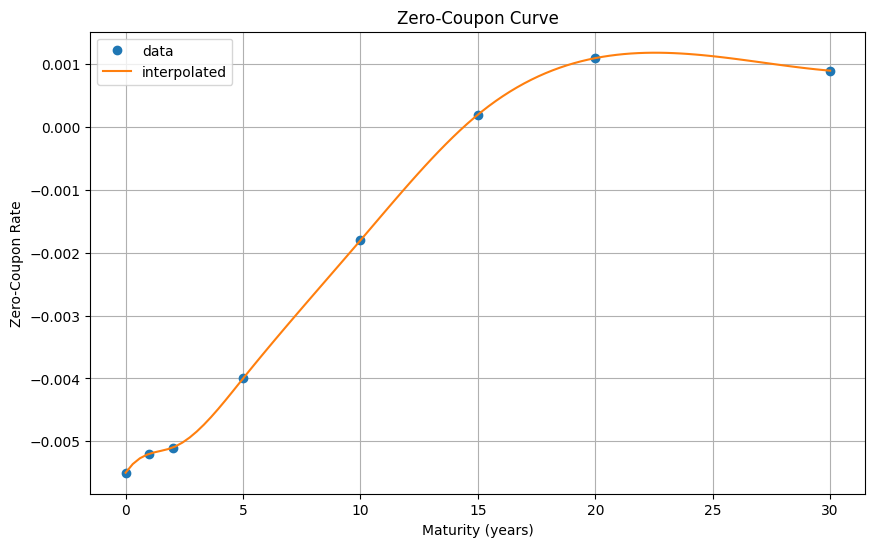

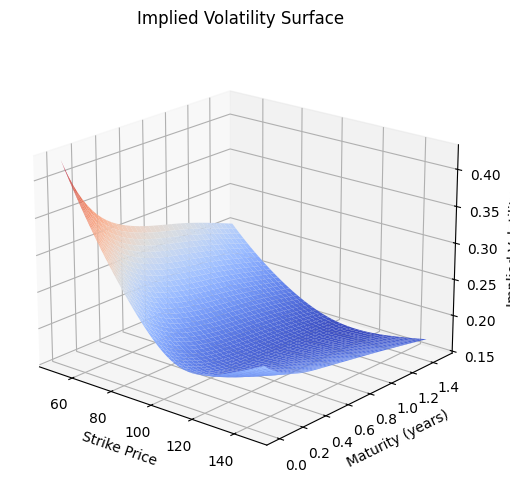

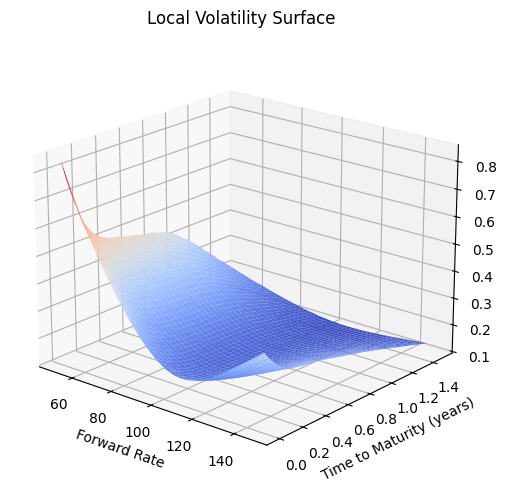

European Call Option Price (Monte Carlo): 6.4209 (95% Confidence Interval: [6.4003, 6.4414])
European Call Option Price (Black): 6.4379
European Call Option Price (Finite Difference Method): 6.4258
Finite Difference Method computation time: 0.06 seconds
Monte Carlo Method computation time: 9.91 seconds
--------------------------------
European Put Option Price (Monte Carlo): 7.0027 (95% Confidence Interval: [6.9812, 7.0242])
European Put Option Price (Black): 6.9593
European Put Option Price (Finite Difference Method): 6.9471
Finite Difference Method computation time: 0.06 seconds
--------------------------------
American Call Option Price (Finite Difference Method): 6.4579
Finite Difference Method computation time: 0.06 seconds
--------------------------------
American Put Option Price (Finite Difference Method): 6.9471
Finite Difference Method computation time: 0.06 seconds
--------------------------------


In [75]:
if __name__ == "__main__":
    main()